In [22]:
import json
# Load gen_path as jsonl
def load_jsonl(file_path):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    return data

# Load coverage_path as a json
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [23]:
from unidecode import unidecode
from nltk.tokenize.casual import casual_tokenize
import numpy as np

def get_ngram_coverage(text, spans, min_gram):
    try:
        tokens = casual_tokenize(unidecode(text))
    except:
        from IPython import embed; embed()
    flags = [False for _ in tokens]
    for span in spans:
        span_length = span['end_index'] - span['start_index']
        if span_length >= min_gram:
            flags[span['start_index']: span['end_index']] = [True] * span_length

    coverage = len([f for f in flags if f]) / len(flags)
    return coverage

def compute_ci_statistic(outputs, min_ngram, max_ngram, add_output_file=None, threshold=None):
    print(f'number of items {len(outputs)}')

    avg_coverages, avg_std = [], []
    ngram_list = list(range(min_ngram, max_ngram + 1))
    for output in outputs:
        coverages = []
        for min_ngram in ngram_list:
            coverage = get_ngram_coverage(output['text'], output['matched_spans'], min_ngram)
            coverages.append(coverage)

        avg_coverages.append(np.sum(coverages))
        avg_std.append(np.std(coverages))

        # print(f'percentage of tokens with a matched {min_ngram}-grams: {np.average(coverages):.3f}, std: {np.std(coverages):.3f}')
        #print(f'percentage of tokens outside of a matched {min_ngram}-grams: {1- np.average(coverages):.3f}, std: {np.std(coverages):.3f}')
    # auc, curvature = sum(avg_coverages), get_curvature(avg_coverages)
    # return auc, curvature

    return avg_coverages


In [24]:
prompt_idx = 1
# Open the jsonl
gen_path = f"/gscratch/xlab/hallisky/membership-inference/tasks/bookMIA/generations/davinci-002_maxTokens512_numSeq1_topP0.95_numSent1_promptIdx{prompt_idx}_len100.jsonl"

min_ngram=4
all_docs = True
doc_string = "alldoc" if all_docs else "onedoc"

coverage_path = gen_path.replace(".jsonl", f"_{min_ngram}_{doc_string}.jsonl").replace("generations", "coverages")

gen_data = load_jsonl(gen_path)
coverage_data = load_json(coverage_path)
cis = compute_ci_statistic(coverage_data, 4, 12)


number of items 99


In [25]:
gen_labels = [g["label"] for g in gen_data]

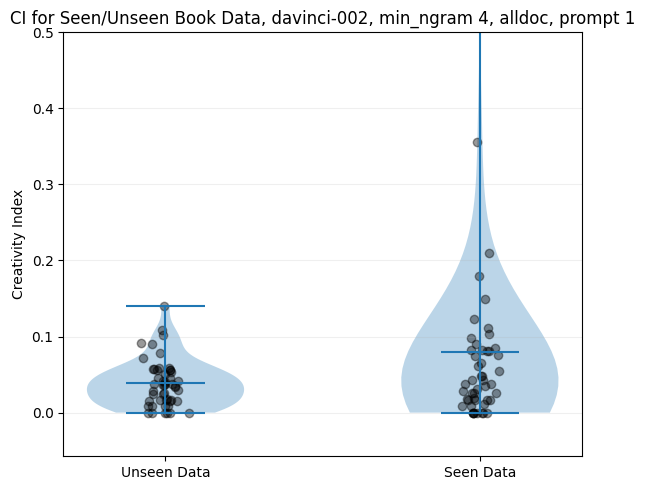

In [48]:
import matplotlib.pyplot as plt
import numpy as np

data_0 = [cis[i] for i in range(len(cis)) if gen_labels[i] == 0]
data_1 = [cis[i] for i in range(len(cis)) if gen_labels[i] == 1]

# Create a violin plot with matplotlib
plt.figure(figsize=(6, 5))
plt.violinplot([data_0, data_1], showmeans=True)

# Add scatter points for each category
x_positions_0 = np.random.normal(1, 0.03, size=len(data_0))  # jitter for category 0
x_positions_1 = np.random.normal(2, 0.03, size=len(data_1))  # jitter for category 1


plt.scatter(x_positions_0, data_0, color='black', alpha=0.4)
plt.scatter(x_positions_1, data_1, color='black', alpha=0.4)

# Adding labels and title
plt.xticks([1, 2], ["Unseen Data", "Seen Data"])
plt.ylabel('Creativity Index')

plt.title(f'CI for Seen/Unseen Book Data, davinci-002, min_ngram {min_ngram}, {doc_string}, prompt {prompt_idx}')
plt.ylim(top=0.5)
plt.grid(alpha=0.2, axis='y')
plt.tight_layout()

folder_path = "/gscratch/xlab/hallisky/membership-inference/tasks/bookMIA/plots"
plt.save_fig(os.path.join(folder_path, f" .png"), dpi=200, bbox_inches="tight")
